In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint, ode, solve_ivp
import seaborn as sns
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import interpolate
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
%run -i '../../../../../utils.py'

# Read data

In [8]:
# read metadata
df_meta = pd.read_excel('../../../../../our_data/meta_data.xlsx', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_meta = df_meta.drop('Diet', axis=1)
df_meta = df_meta.rename({'MiceID':'SubjectID'}, axis=1)

# read SCFA
df_scfa = pd.read_excel('../../../../../our_data/SCFA.xlsx', index_col=0)

# read bacterial absolute abundance
df_bac = pd.read_excel('../../../../../our_data/16S_absolute_abundance.xlsx', index_col=0)
df_bac = df_bac/df_bac.max().max()

# Intrapolation

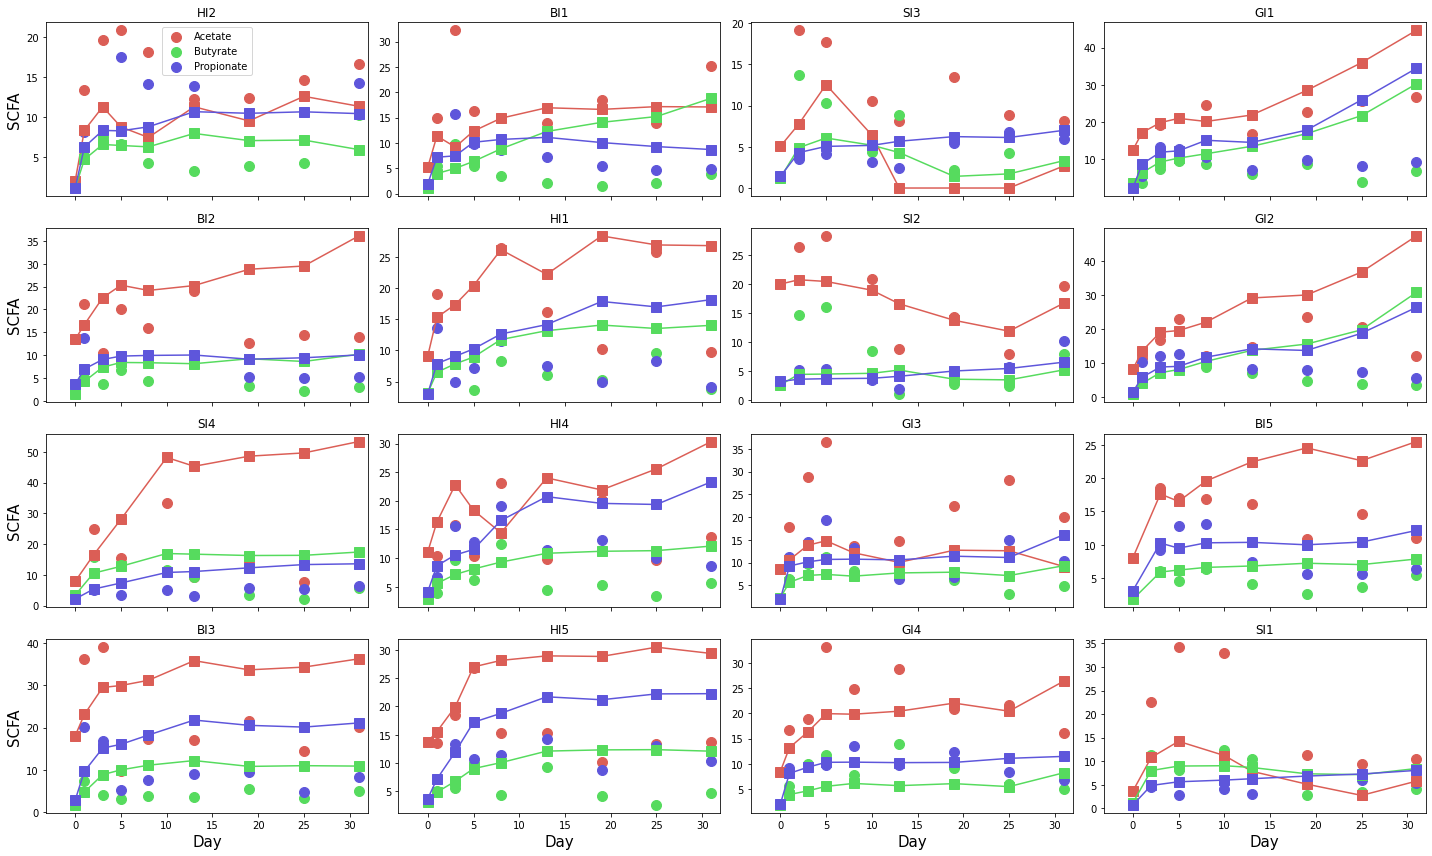

In [9]:
df_intra = get_rf_prediction_error(
    df_meta=df_meta,
    df_scfa=df_scfa,
    df_bac=df_bac,
    target_scfa=['Acetate','Butyrate','Propionate'],
    prediction_type='intrapolation',
    topN=40,
    is_plot=True,
    save_fig=False,
    use_deriv_scfa=True,
    use_deriv_microbiome=True
)
df_intra.to_csv('prediction_error_intrapolation.csv')

# Extrapolation

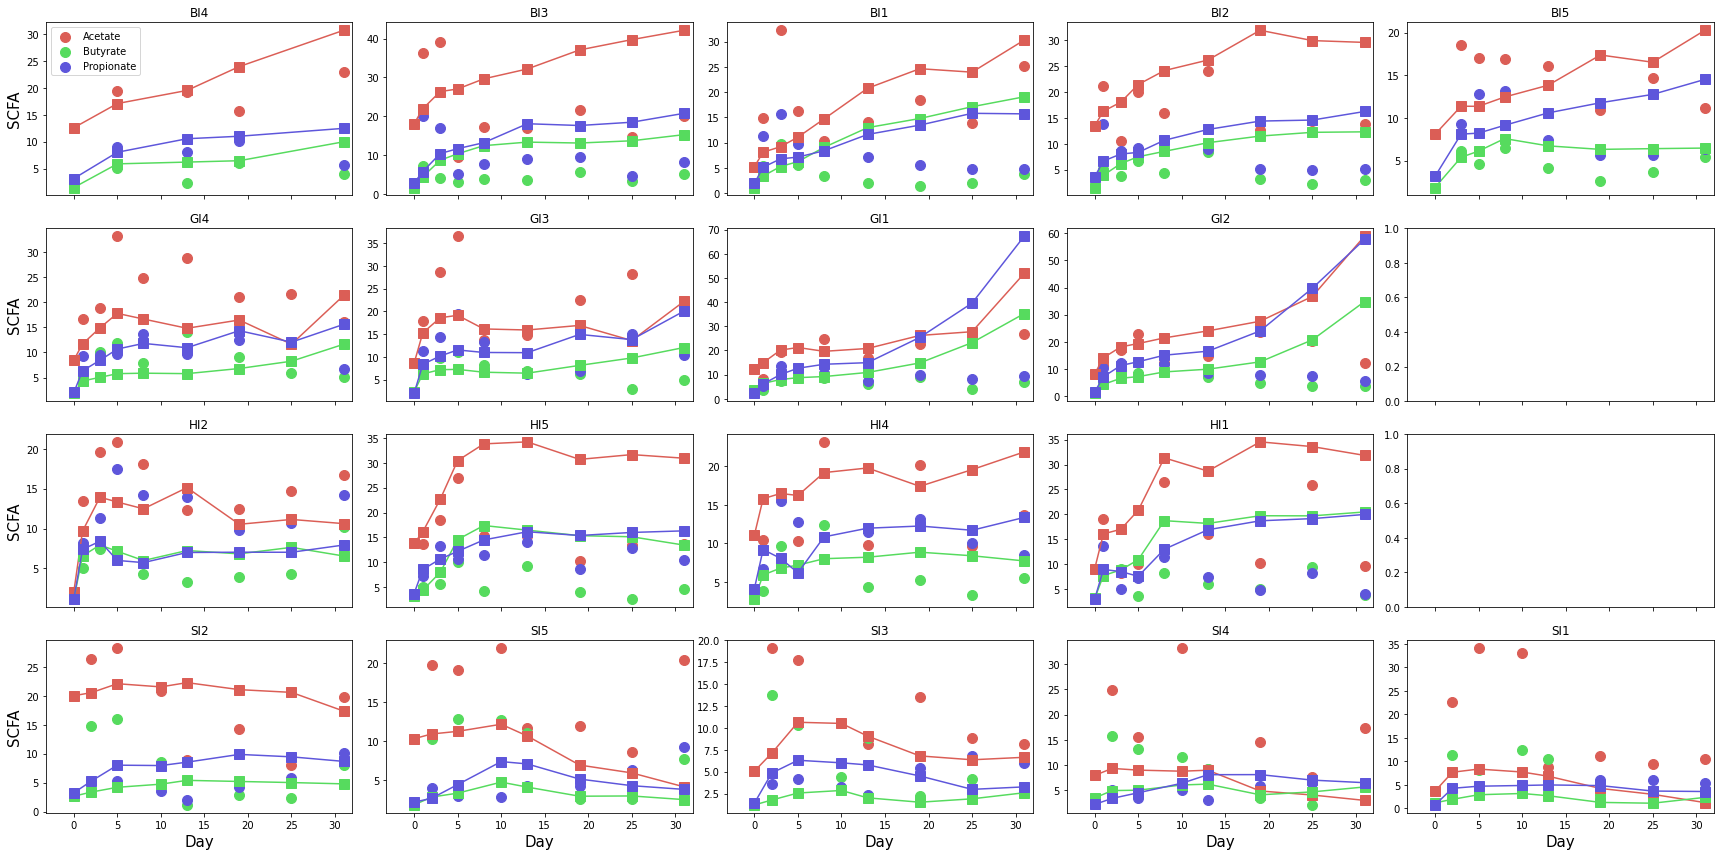

In [10]:
df_extra = get_rf_prediction_error(
    df_meta=df_meta,
    df_scfa=df_scfa,
    df_bac=df_bac,
    target_scfa=['Acetate','Butyrate','Propionate'],
    prediction_type='extrapolation',
    topN=40,
    is_plot=True,
    save_fig=False,
    use_deriv_scfa=True,
    use_deriv_microbiome=True
)
df_extra.to_csv('prediction_error_extrapolation.csv')

# Plot training vs. prediction

In [11]:
df_intra = pd.read_csv('prediction_error_intrapolation.csv', index_col=0)
df_intra['Perturbation'] = 'intrapolation'
df_extra = pd.read_csv('prediction_error_extrapolation.csv', index_col=0)
df_extra['Perturbation'] = 'extrapolation'
df_train_test = pd.concat([df_intra,df_extra], ignore_index=True)
df_train_test.to_csv('prediction_error_combined.csv')
df_train_test.head()

,SubjectID,Vendor,Day,RandomizedGroup,SCFA_value_observed,SCFA_deriv_observed,SCFA_deriv_predicted,SCFA_mol,SCFA_value_predicted,RelativeError_SCFA_value,RelativeError_SCFA_deriv,Perturbation
0,HI2,Hunan,0,A,2.061243,15.751307,7.299113,Acetate,2.061243,0.000000,-53.660270,intrapolation
1,HI2,Hunan,1,A,13.413769,7.504297,3.930009,Acetate,8.355394,-37.710323,-47.629886,intrapolation
2,HI2,Hunan,3,A,19.636050,0.920187,-0.277674,Acetate,11.299130,-42.457216,-130.175776,intrapolation
3,HI2,Hunan,5,A,20.876405,0.008909,-1.987197,Acetate,8.783324,-57.927028,-22405.958057,intrapolation
4,HI2,Hunan,8,A,18.106668,-1.403764,0.966999,Acetate,7.468640,-58.751991,-168.886138,intrapolation


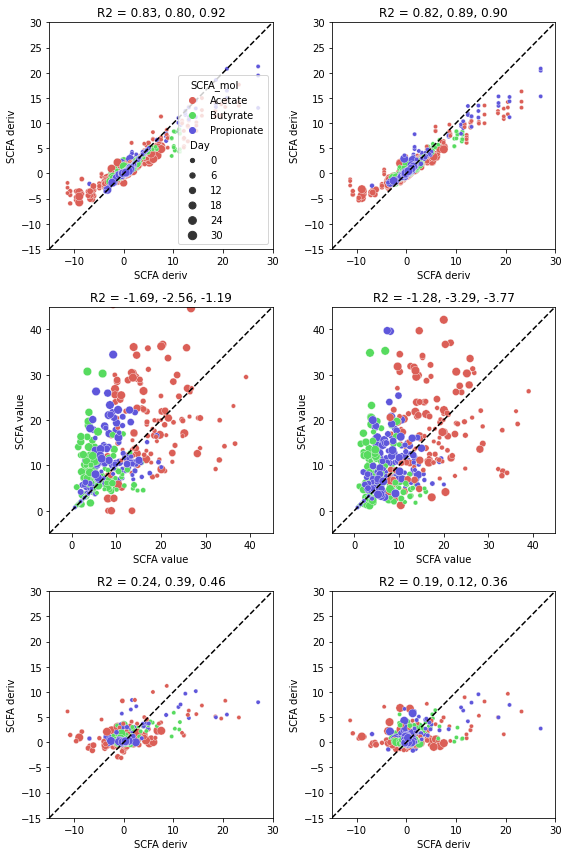

In [38]:
fig, ax = plt.subplots(figsize=(8,12), nrows=3, ncols=2)

# training, intrapolation
lines_R2 = []
df = pd.read_csv('intrapolation/training_error_intrapolation.csv')
_ = sns.scatterplot(x='SCFA_observed',y='SCFA_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[0,0])
_ = ax[0,0].plot([-15,30],[-15,30],'k--')
_ = ax[0,0].set_xlim([-15,30])
_ = ax[0,0].set_ylim([-15,30])
_ = ax[0,0].set_xlabel('SCFA deriv')
_ = ax[0,0].set_ylabel('SCFA deriv')

r2_ac = r2_score(df[df.SCFA_mol=='Acetate'].SCFA_observed, df[df.SCFA_mol=='Acetate'].SCFA_predicted)
r2_but = r2_score(df[df.SCFA_mol=='Butyrate'].SCFA_observed, df[df.SCFA_mol=='Butyrate'].SCFA_predicted)
r2_ppa = r2_score(df[df.SCFA_mol=='Propionate'].SCFA_observed, df[df.SCFA_mol=='Propionate'].SCFA_predicted)
lines_R2.append(['intrapolation','training','deriv','acetate',r2_ac])
lines_R2.append(['intrapolation','training','deriv','butyrate',r2_but])
lines_R2.append(['intrapolation','training','deriv','propionate',r2_ppa])
_ = ax[0,0].set_title('R2 = %2.2f, %2.2f, %2.2f'%(r2_ac,r2_but,r2_ppa))

# training, extrapolation
df = pd.read_csv('extrapolation/training_error_extrapolation.csv')
_ = sns.scatterplot(x='SCFA_observed',y='SCFA_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[0,1])
_ = ax[0,1].plot([-15,30],[-15,30],'k--')
_ = ax[0,1].set_xlim([-15,30])
_ = ax[0,1].set_ylim([-15,30])
_ = ax[0,1].set_xlabel('SCFA deriv')
_ = ax[0,1].set_ylabel('SCFA deriv')

r2_ac = r2_score(df[df.SCFA_mol=='Acetate'].SCFA_observed, df[df.SCFA_mol=='Acetate'].SCFA_predicted)
r2_but = r2_score(df[df.SCFA_mol=='Butyrate'].SCFA_observed, df[df.SCFA_mol=='Butyrate'].SCFA_predicted)
r2_ppa = r2_score(df[df.SCFA_mol=='Propionate'].SCFA_observed, df[df.SCFA_mol=='Propionate'].SCFA_predicted)
lines_R2.append(['extrapolation','training','deriv','acetate',r2_ac])
lines_R2.append(['extrapolation','training','deriv','butyrate',r2_but])
lines_R2.append(['extrapolation','training','deriv','propionate',r2_ppa])
_ = ax[0,1].set_title('R2 = %2.2f, %2.2f, %2.2f'%(r2_ac,r2_but,r2_ppa))
ax[0,1].legend().remove()

# testing
for i,quantity in enumerate(['value','deriv']):
    for k,perturbation in enumerate(['intrapolation','extrapolation']):
        df = df_train_test[df_train_test.Perturbation==perturbation]
        _ = sns.scatterplot(x='SCFA_%s_observed'%(quantity),y='SCFA_%s_predicted'%(quantity), hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[i+1,k])
        if quantity=='deriv':
            _ = ax[i+1,k].plot([-15,30],[-15,30],'k--')
            _ = ax[i+1,k].set_xlim([-15,30])
            _ = ax[i+1,k].set_ylim([-15,30])
        else:
            _ = ax[i+1,k].plot([-5,45],[-5,45],'k--')
            _ = ax[i+1,k].set_xlim([-5,45])
            _ = ax[i+1,k].set_ylim([-5,45])
        r2_ac = r2_score(df[df.SCFA_mol=='Acetate']['SCFA_%s_observed'%(quantity)], df[df.SCFA_mol=='Acetate']['SCFA_%s_predicted'%(quantity)])
        r2_but = r2_score(df[df.SCFA_mol=='Butyrate']['SCFA_%s_observed'%(quantity)], df[df.SCFA_mol=='Butyrate']['SCFA_%s_predicted'%(quantity)])
        r2_ppa = r2_score(df[df.SCFA_mol=='Propionate']['SCFA_%s_observed'%(quantity)], df[df.SCFA_mol=='Propionate']['SCFA_%s_predicted'%(quantity)])
        lines_R2.append([perturbation,'testing',quantity,'acetate',r2_ac])
        lines_R2.append([perturbation,'testing',quantity,'butyrate',r2_but])
        lines_R2.append([perturbation,'testing',quantity,'propionate',r2_ppa])
        _ = ax[i+1,k].set_title('R2 = %2.2f, %2.2f, %2.2f'%(r2_ac,r2_but,r2_ppa))
        ax[i+1,k].legend().remove()
        _ = ax[i+1,k].set_xlabel('SCFA %s'%(quantity))
        _ = ax[i+1,k].set_ylabel('SCFA %s'%(quantity))
            
plt.tight_layout()

df_r2 = pd.DataFrame(lines_R2, columns=['Perturbation','Train_or_test','Value_or_deriv','SCFA','R2'])

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatter_plot_training_prediction.svg", format="svg")

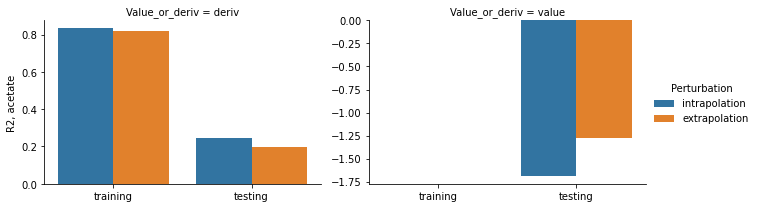

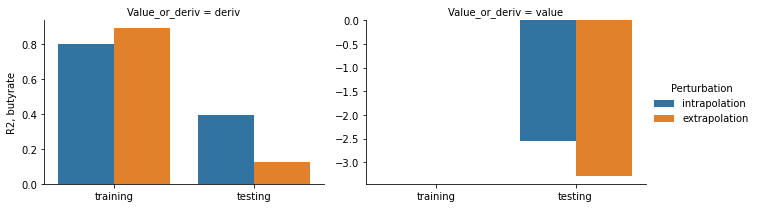

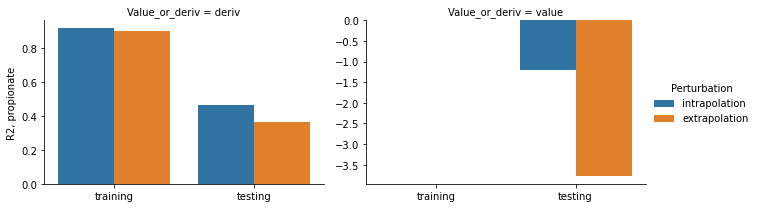

In [45]:
for scfa_ in ['acetate','butyrate','propionate']:
    g=sns.catplot(x='Train_or_test', y='R2', hue='Perturbation', col='Value_or_deriv', data=df_r2[df_r2.SCFA==scfa_], kind='bar', height=3, aspect=1.5, sharey=False)
    g.set_axis_labels("", "R2, %s"%(scfa_))